In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import numpy as np
import os
import pvtrace
import scintillator_tracer as st

# Readout and left cut

In [3]:
ANGLE = 90
READOUT_LEFT_CUT_STL = '/home/reed/Documents/research/grimpress/crystal-geometry/notebooks/isosceles_prisms/cut_progression/models/readout-left-cut-Body.stl'
READOUT_LEFT_CUT_ESR_SHELL_STL = '/home/reed/Documents/research/grimpress/crystal-geometry/notebooks/isosceles_prisms/cut_progression/models/readout-left-cut-esr-shell-Body.stl'

In [4]:
def build_readout_left_cut_world(
    angle: float,
    crystal_kwargs: dict = {},
    esr_shell_kwargs: dict = {},
    optical_pad_kwargs: dict = {},
    sipm_kwargs: dict = {},
    world: pvtrace.Node = None
) -> dict:
    """
    Angle is in degrees.
    """

    if world is None:
        world = st.definitions.generate_world()
    
    SCALING = np.cos(np.radians(45))
    DEFAULT_KWARGS = dict(
        crystal = dict(
            stl_file=READOUT_LEFT_CUT_STL.format(angle=angle),
            scaling=0.1,
            world=world
        ),
        esr_shell = dict(
            stl_file=READOUT_LEFT_CUT_ESR_SHELL_STL.format(angle=angle),
            scaling=0.1,
            world=world
        ),
        optical_pad = dict(
            world=world,
            size=(0.4/SCALING, 6.6, 0.01)
        ),
        sipm = dict(
            world=world,
            size=(0.6, 6.6, 0.05)
        )
    )

    crystal = st.definitions.generate_crystal(**{**DEFAULT_KWARGS['crystal'], **crystal_kwargs})
    esr_shell = st.definitions.generate_esr_shell(**{**DEFAULT_KWARGS['esr_shell'], **esr_shell_kwargs})
    optical_pad = st.definitions.generate_optical_pad(**{**DEFAULT_KWARGS['optical_pad'], **optical_pad_kwargs})
    sipm = st.definitions.generate_sipm(**{**DEFAULT_KWARGS['sipm'], **sipm_kwargs})
    
    st.worlds.basic_stack(crystal, esr_shell, optical_pad, sipm, 0.0101)

    crystal_width = st.geometry_helpers.max_physical_value(crystal, 'x') - \
        st.geometry_helpers.min_physical_value(crystal, 'x')
    pad_thickness = st.geometry_helpers.max_physical_value(optical_pad, 'z') - \
        st.geometry_helpers.min_physical_value(optical_pad, 'z')
    sipm_thickness = st.geometry_helpers.max_physical_value(sipm, 'z') - \
        st.geometry_helpers.min_physical_value(sipm, 'z')
    angle = 45
    h = crystal_width / np.tan( np.radians(90-angle) )
    movex = -pad_thickness/2 * np.sin( np.radians(angle) )
    movez = -( h/2 + pad_thickness/2 )

    optical_pad.translate((0, 0, movez))
    optical_pad.rotate(np.radians(angle), (0, 1, 0))
    optical_pad.translate((-movex, 0, pad_thickness/2 * np.cos(np.radians(angle))))

    movex = -(sipm_thickness/2+pad_thickness) * np.sin(np.radians(angle))
    movez = -(h/2 + pad_thickness + sipm_thickness/2)
    sipm.translate((0, 0, movez))
    sipm.rotate(np.radians(angle), (0, 1, 0))
    sipm.translate((-movex, 0, (sipm_thickness/2+pad_thickness) * np.cos(np.radians(angle))))

    nodes = dict(
        world=world,
        crystal=crystal,
        esr_shell=esr_shell,
        optical_pad=optical_pad,
        sipm=sipm
    )

    return nodes

## Verification

In [7]:
world_func = functools.partial(build_readout_left_cut_world, angle=ANGLE)
nodes = world_func()
world = nodes['world']

height = st.geometry_helpers.get_node_height(nodes['crystal'])
light = st.definitions.generate_scintillated_light_node(world)
light.location = (0, 0, height/2)

scene = pvtrace.Scene(world)
all_ray_steps = st.processing.process_photons_with_visual(scene, 100, seed=100, open_browser=True)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


## Grid trials

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


/home/reed/Documents/research/grimpress/crystal-geometry/scintillator_tracer/plotting.py:91: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  C = ax.pcolormesh(Y, Z, surface, **pcolorkwargs)


varying_optical_pad_thickness/0.1/runs_20240930T131717/figures/crystal_absorbed.png
varying_optical_pad_thickness/0.1/runs_20240930T131717/figures/optical pad_absorbed.png
varying_optical_pad_thickness/0.1/runs_20240930T131717/figures/sipm_absorbed.png


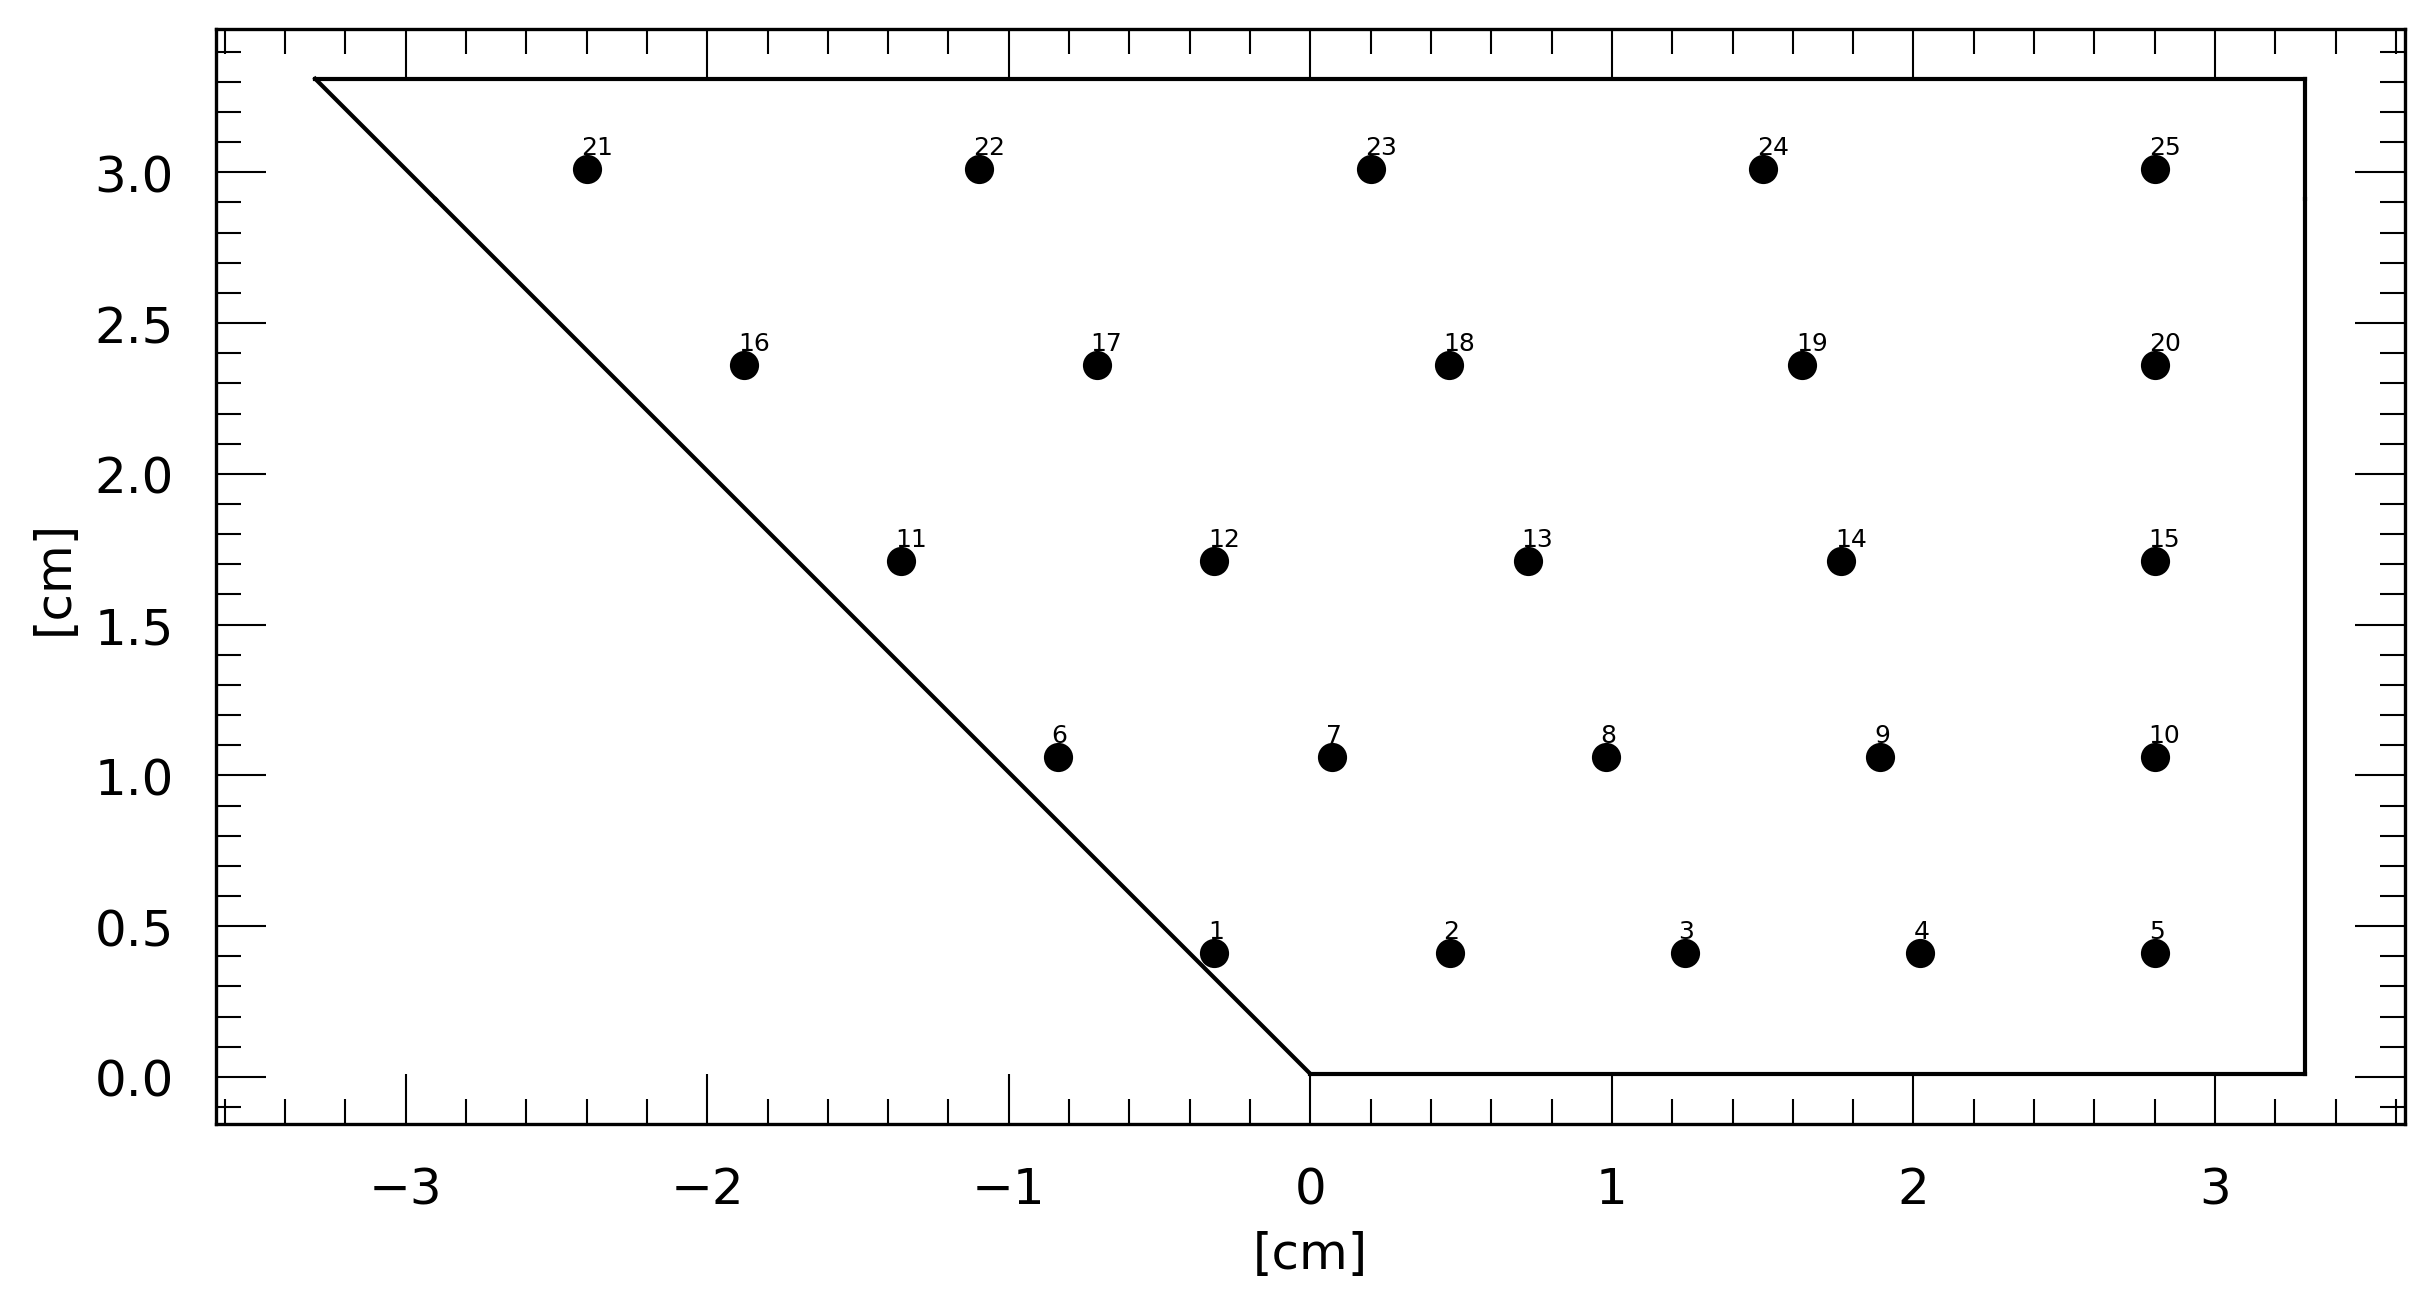

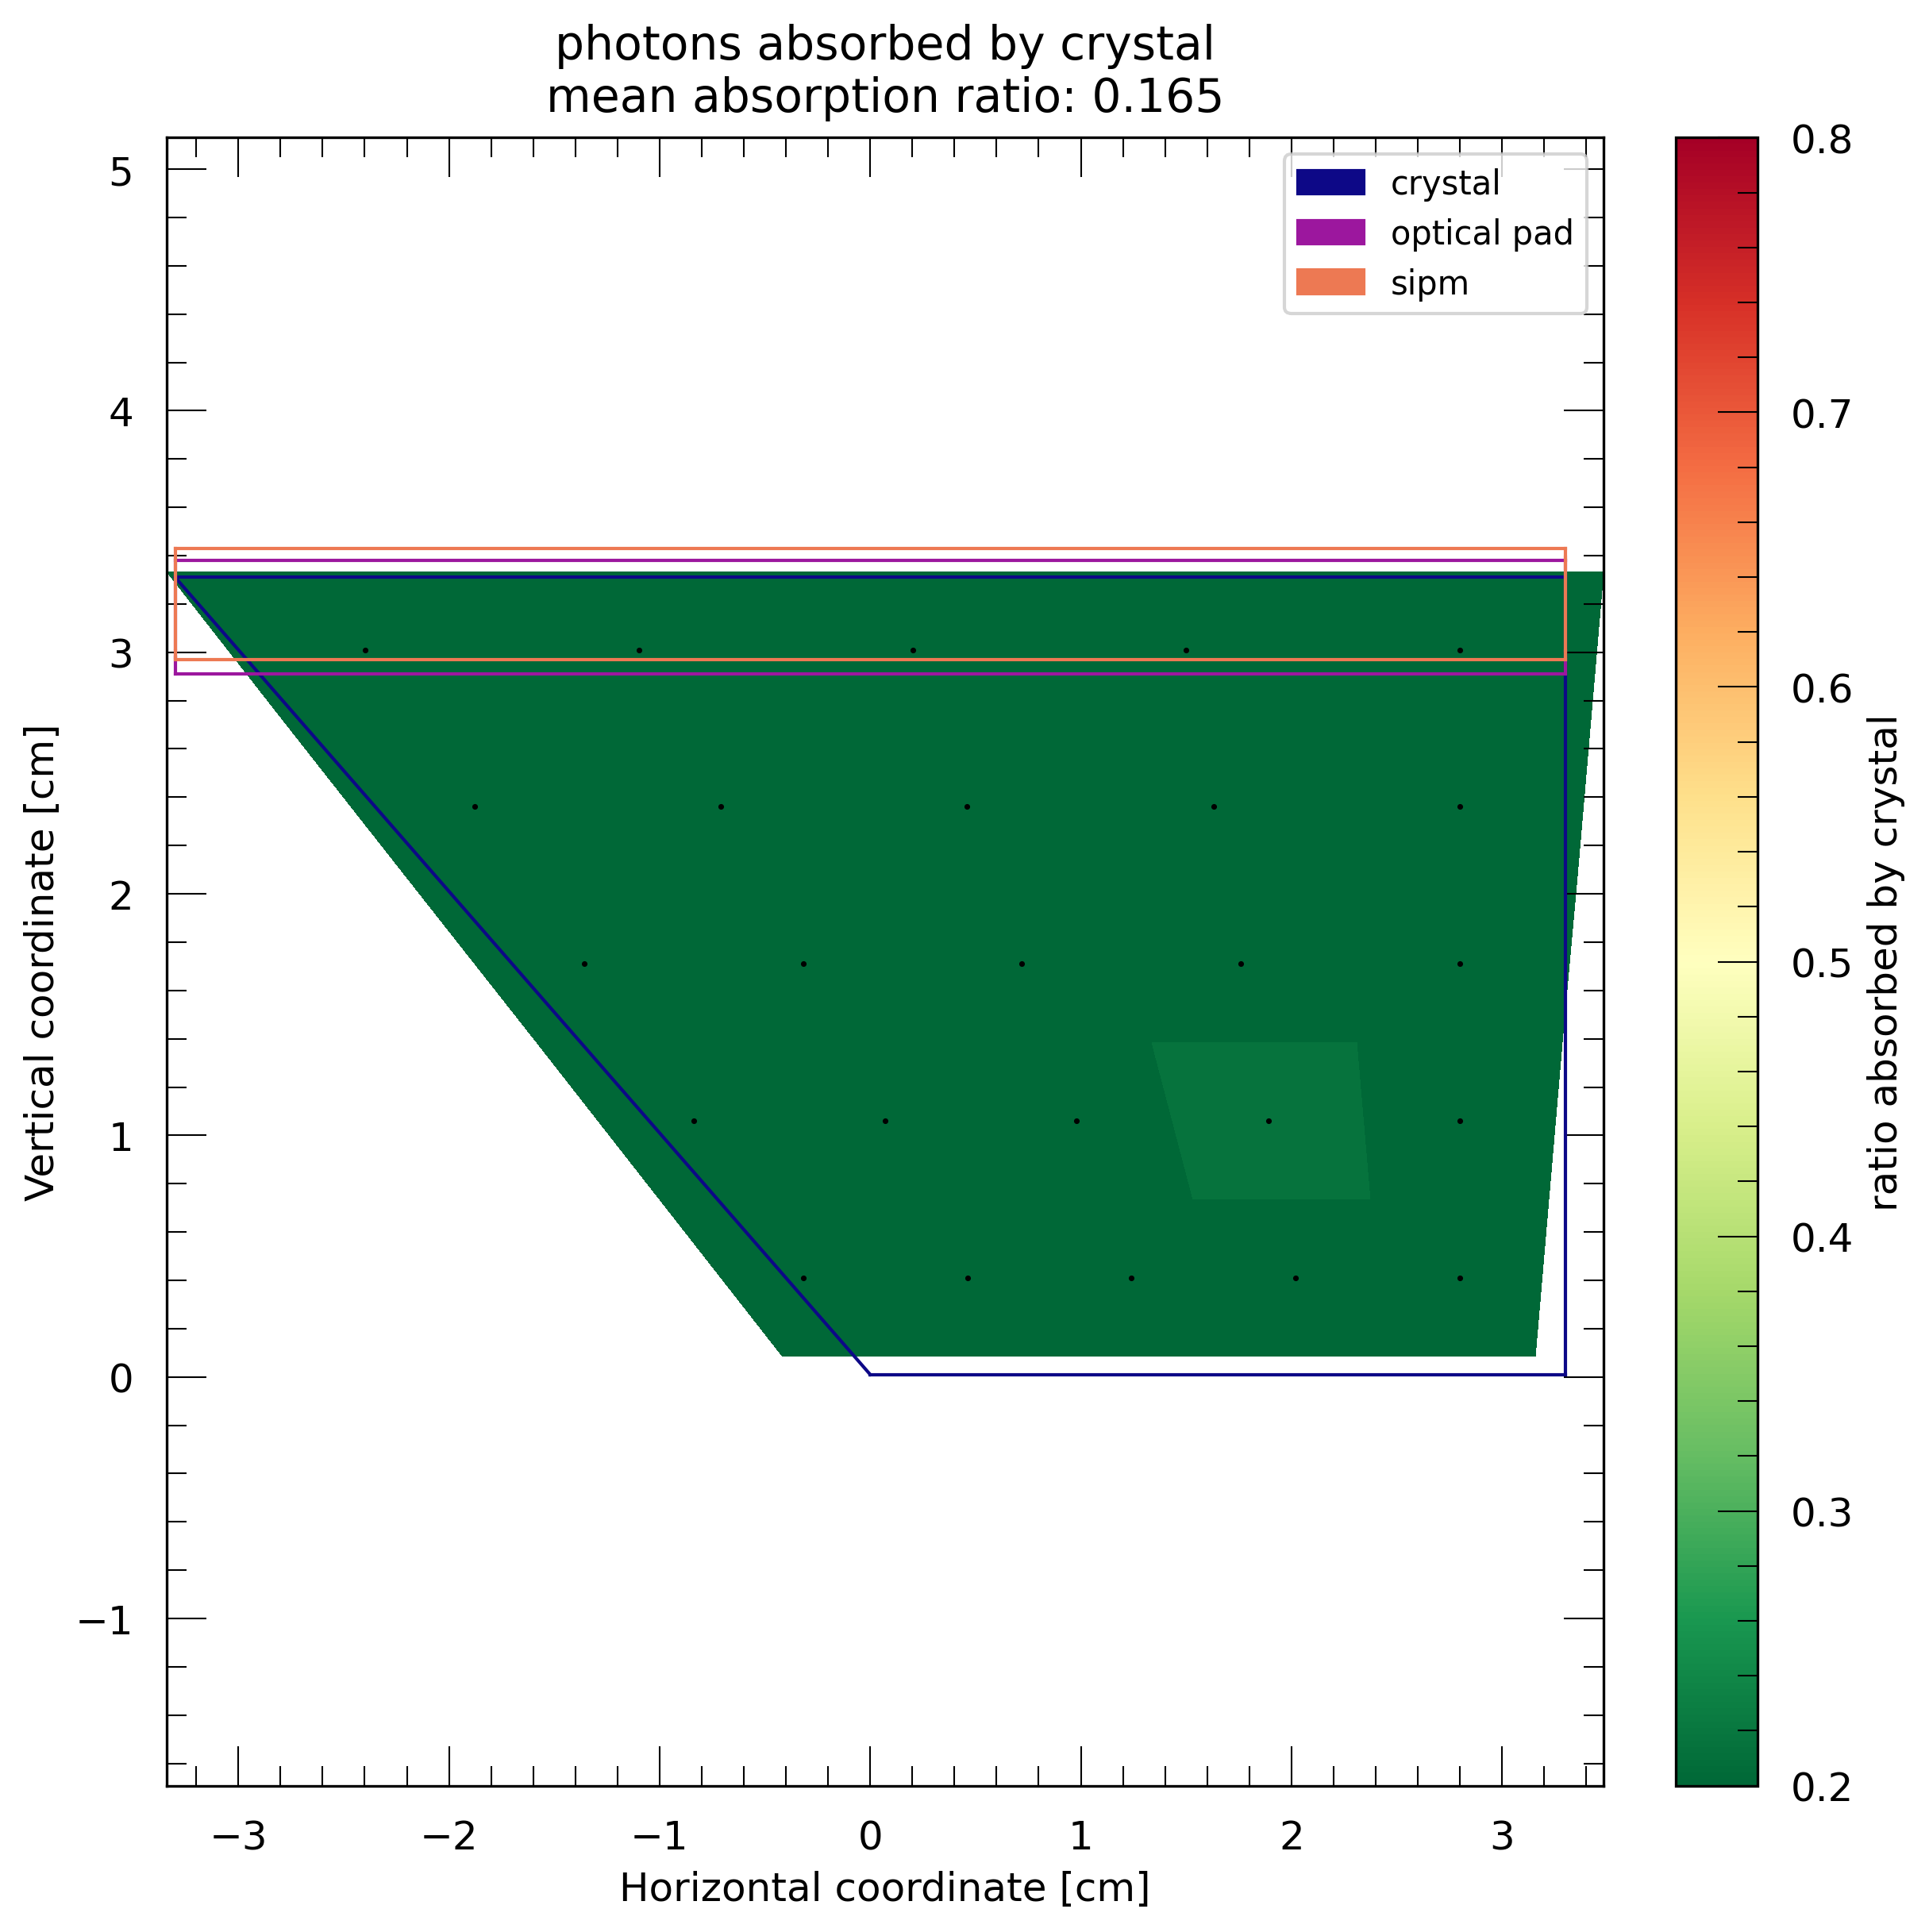

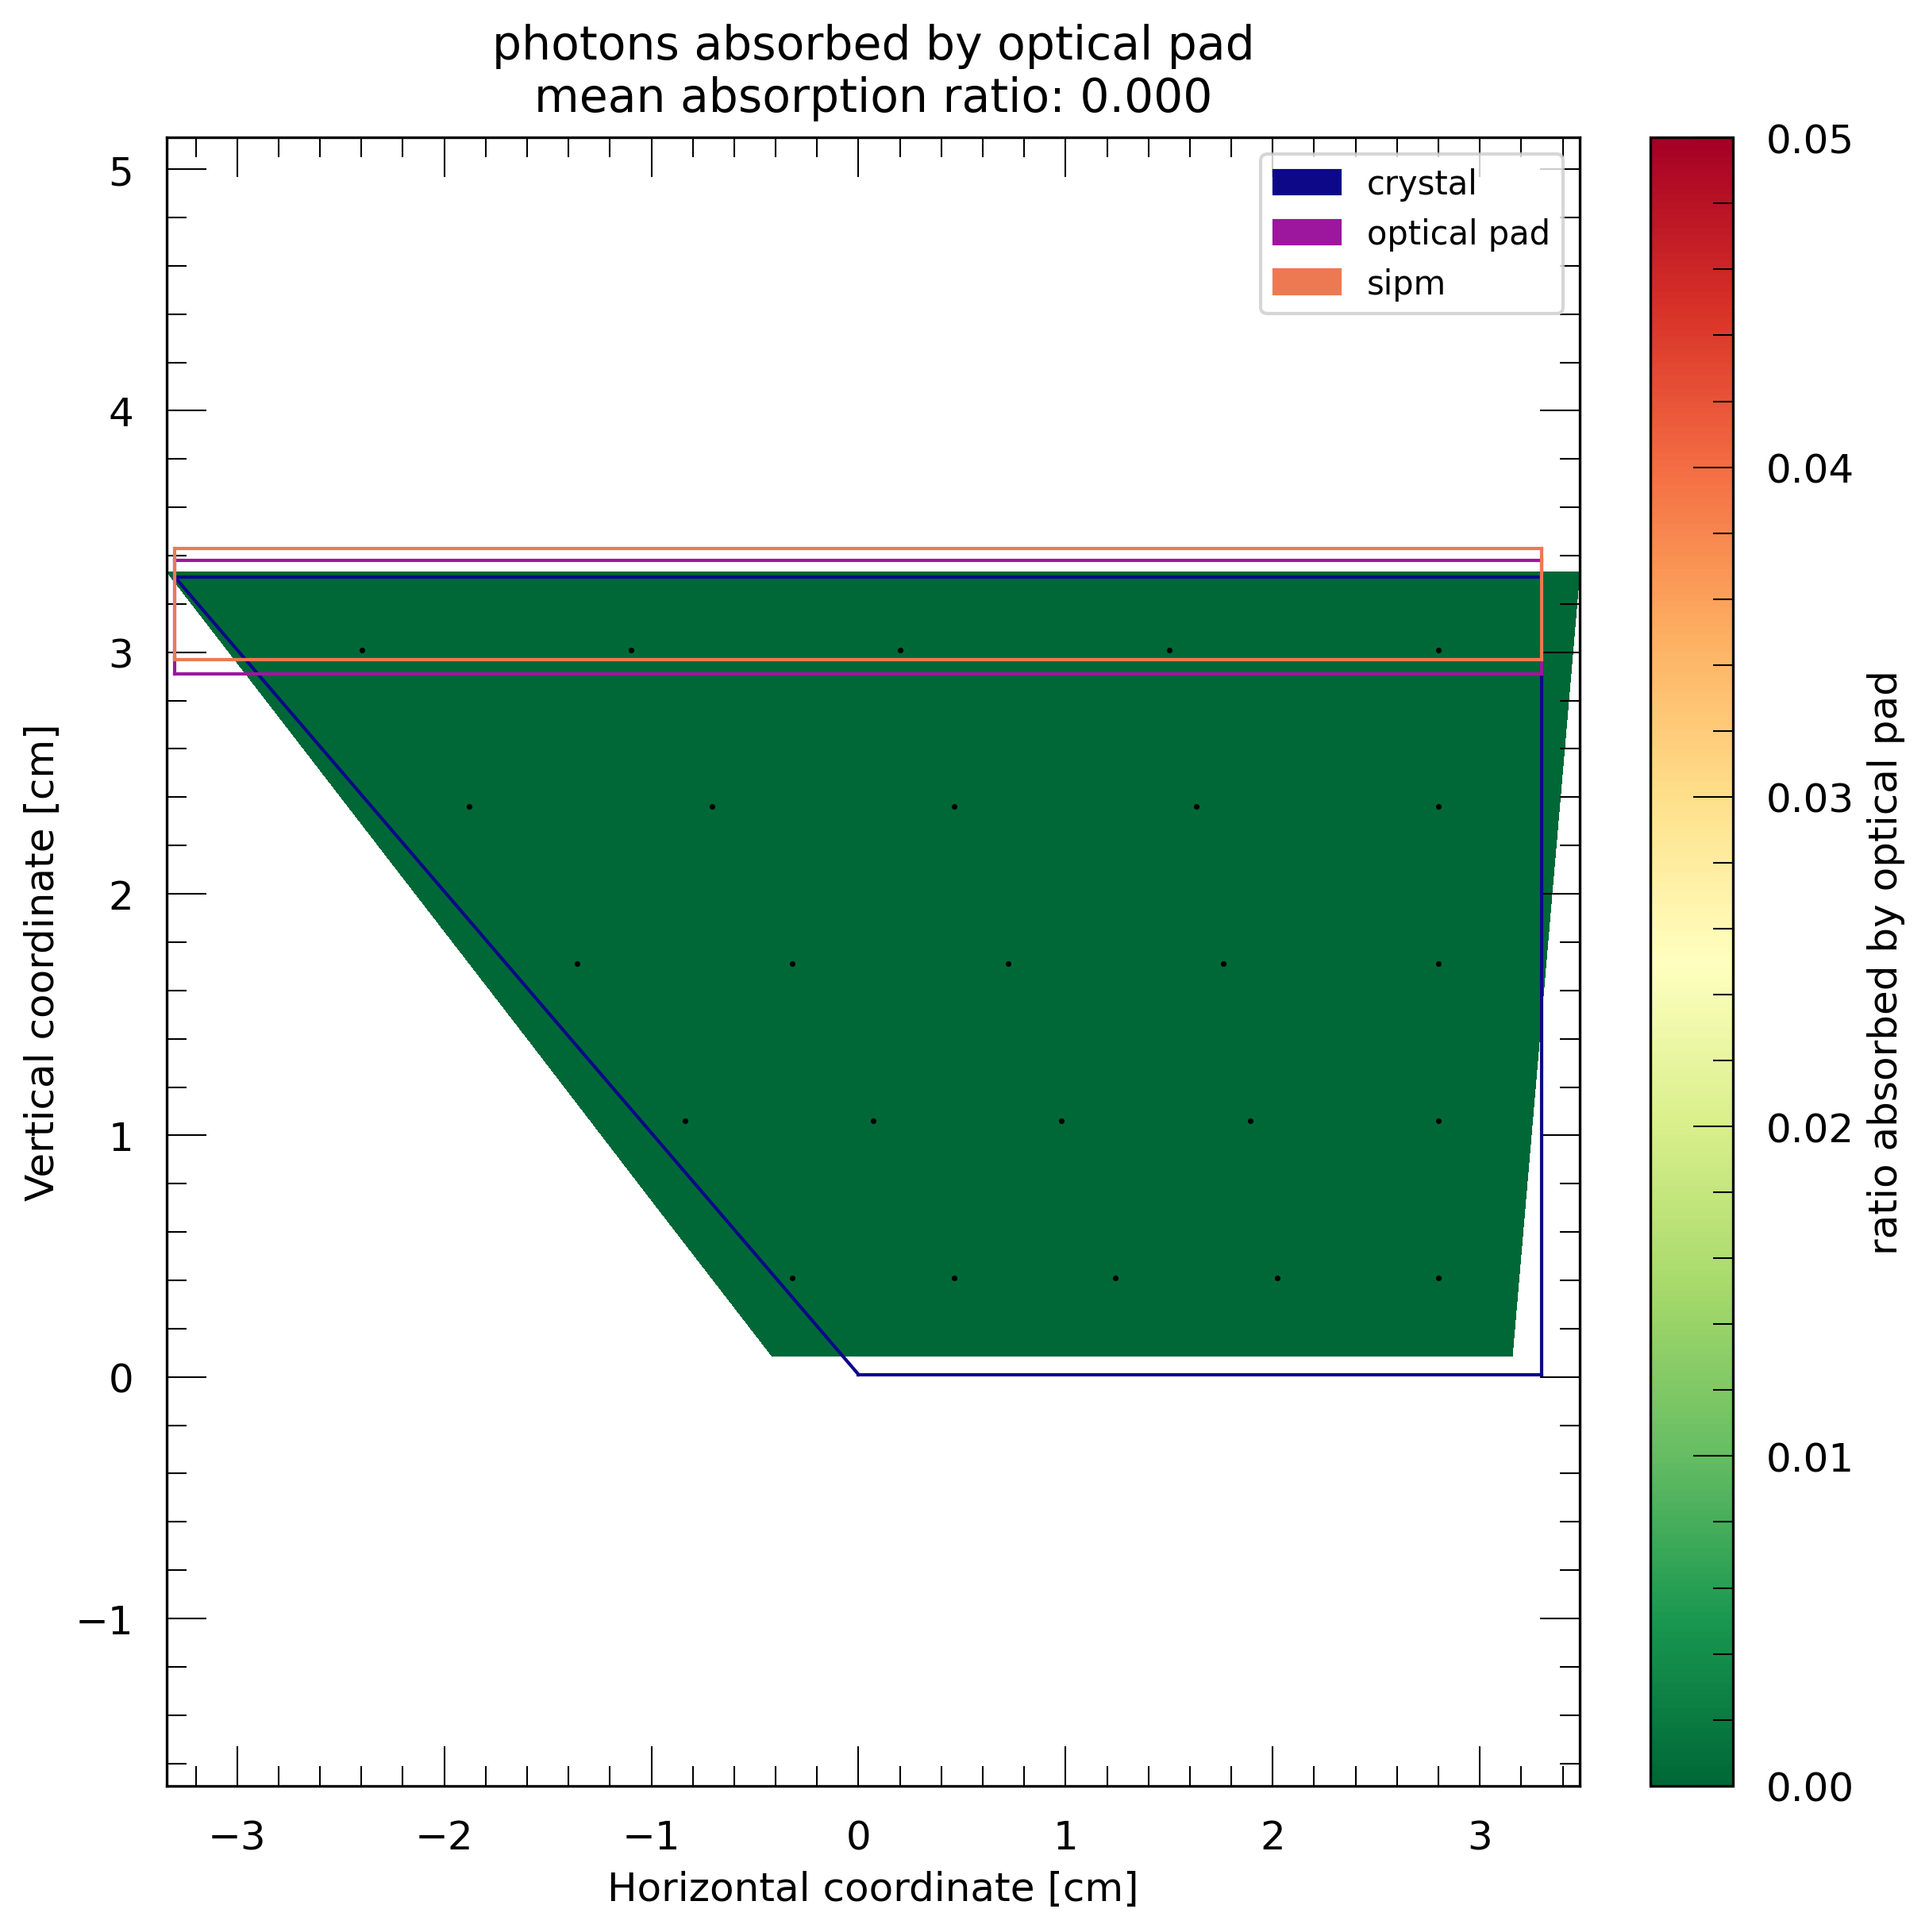

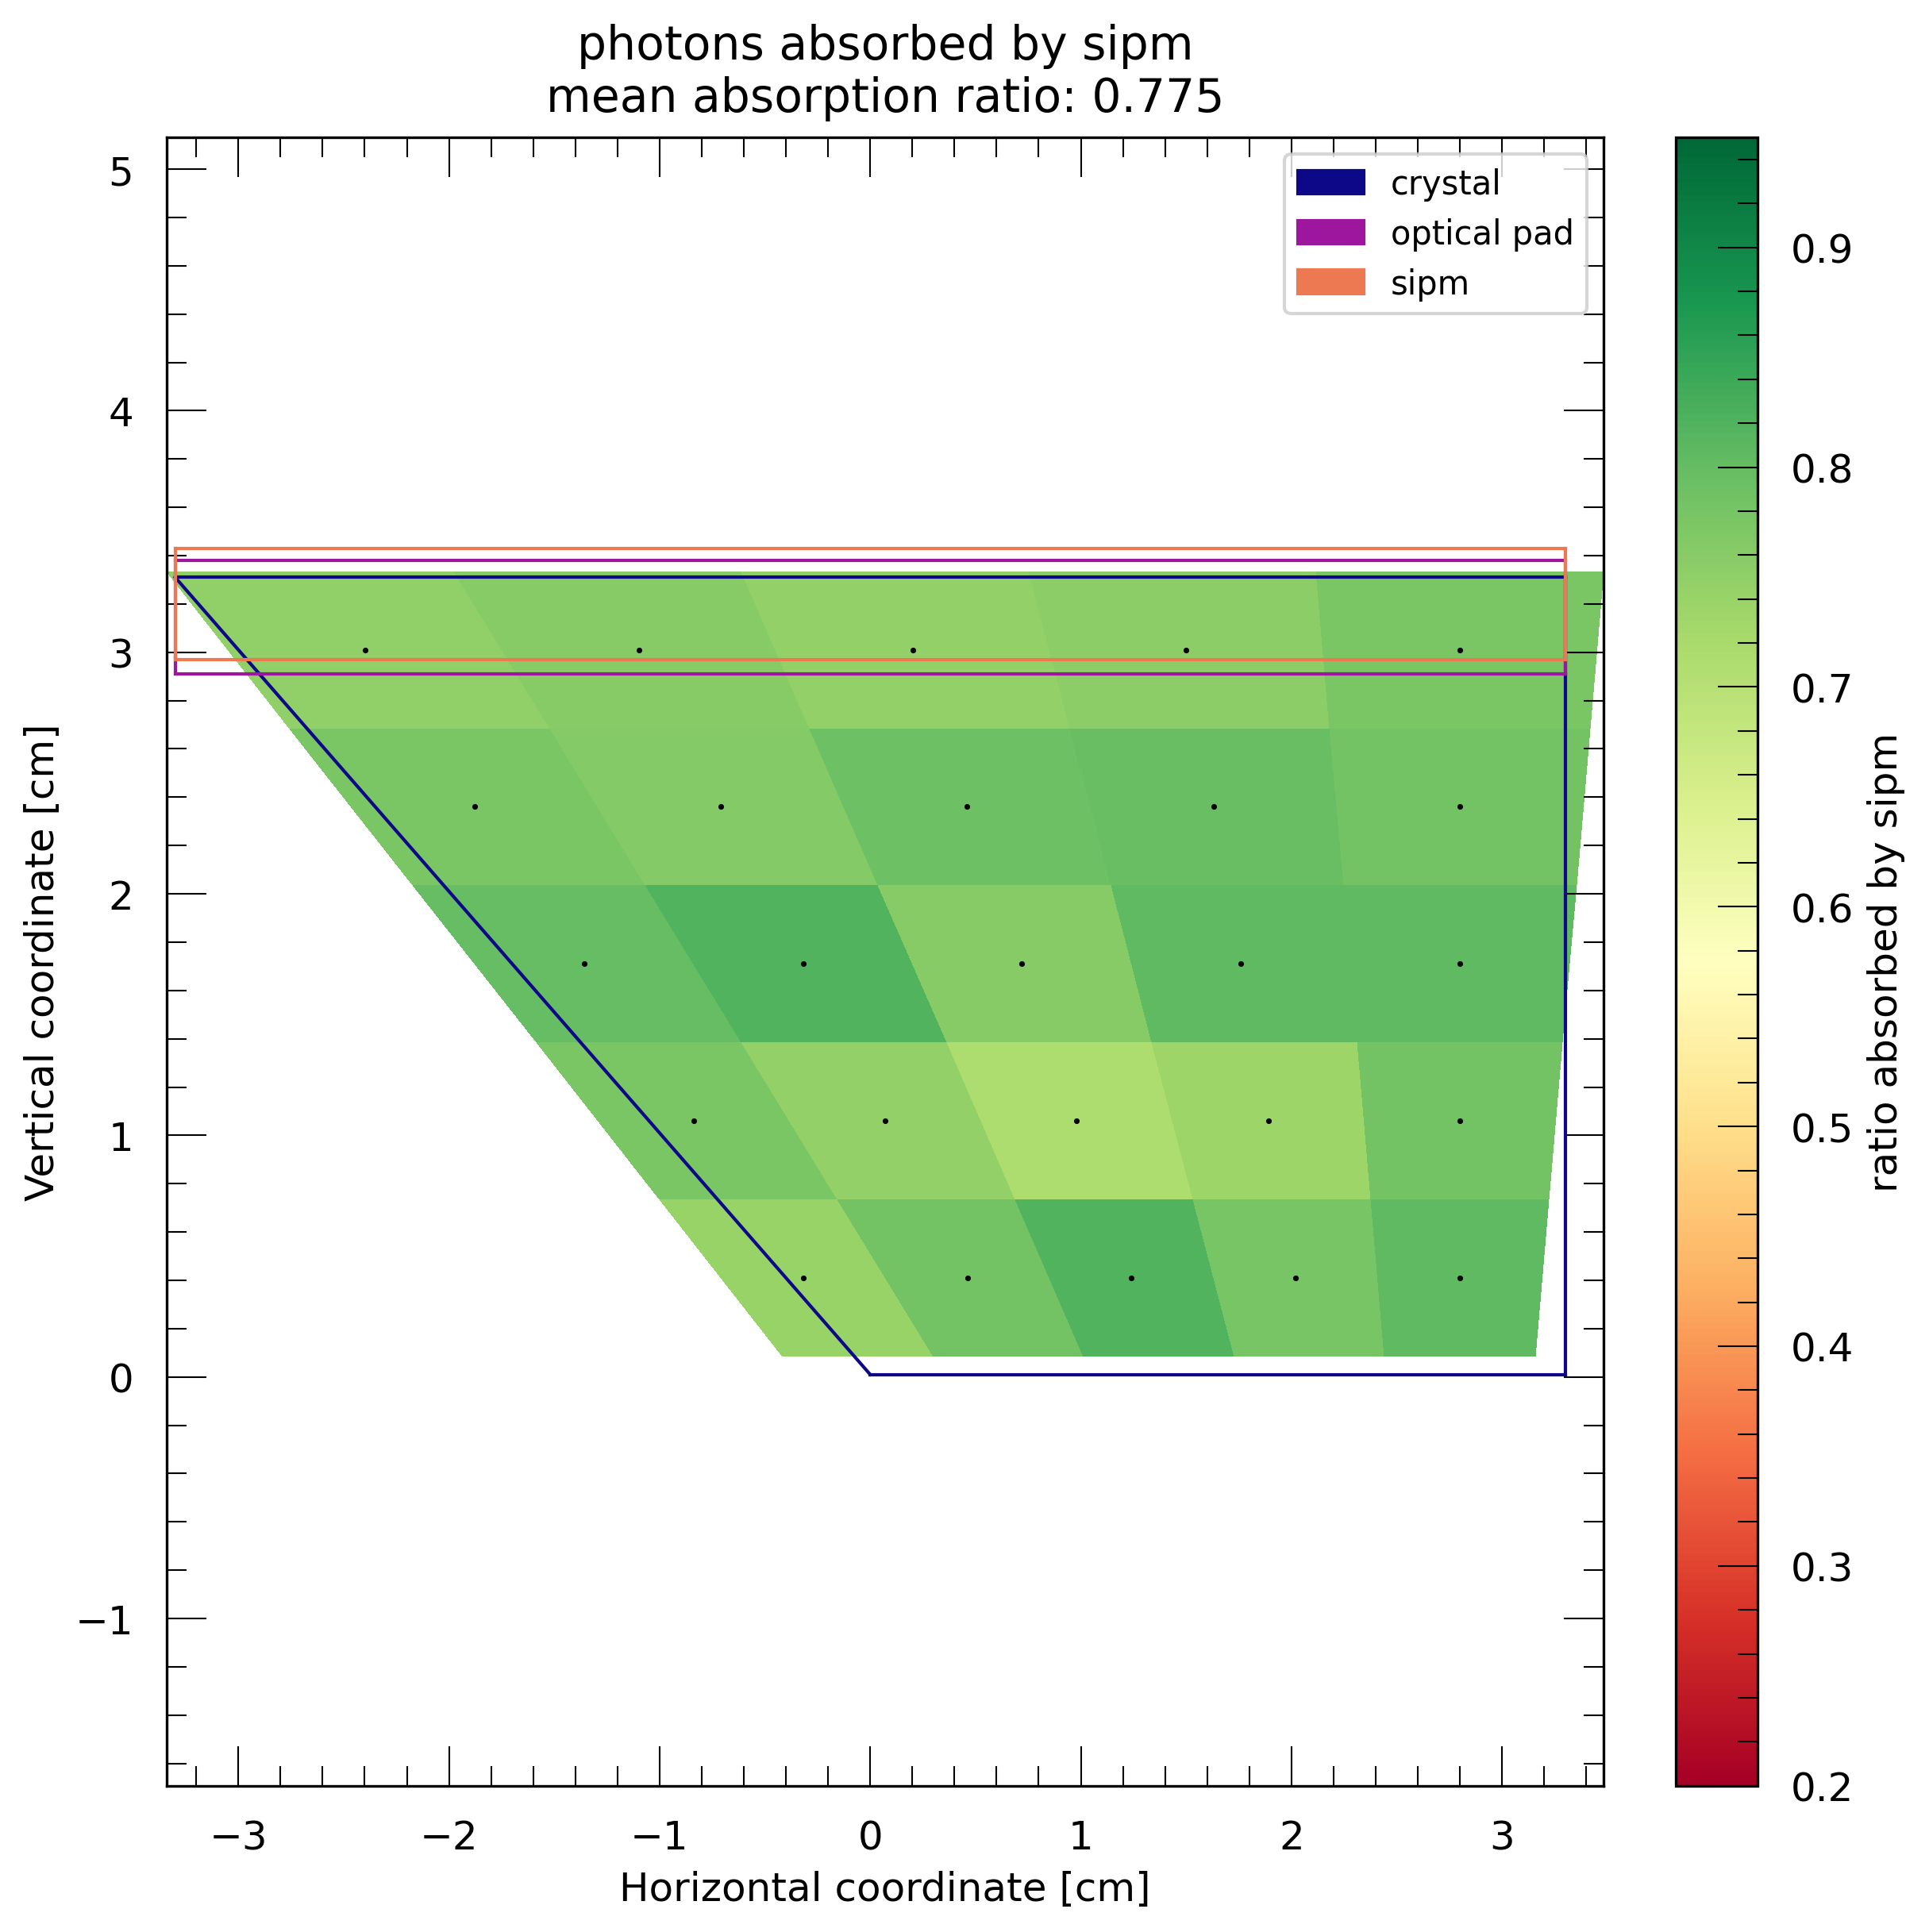

In [5]:
trange = np.arange(0.1, 0.11, 0.01)
for thickness in trange:

    SCALING = np.cos(np.radians(45))
    optical_pad_kwargs = dict(size=(0.4/SCALING, 6.6, thickness))
    world_func = functools.partial(build_readout_left_cut_world, angle=ANGLE, optical_pad_kwargs=optical_pad_kwargs)
    nodes = world_func()
    crystal = nodes['crystal']

    zrange = (
        st.geometry_helpers.min_physical_value(crystal, 'z')+0.4,
        st.geometry_helpers.max_physical_value(crystal, 'z')-0.3,
    )
    yrange = (
        st.geometry_helpers.min_physical_value(crystal, 'y')+0.5,
        st.geometry_helpers.max_physical_value(crystal, 'y')-0.5,
    )

    steps = 5
    man = st.processing.Manager(world_func, out_dir=f'varying_optical_pad_thickness/{thickness}/')
    man.define_grid(
        vertical_range=zrange,
        horizontal_func=lambda z: (-0.8*z+0.01, yrange[1]),
        steps=steps,
        visualize=True
    )

    runs = man.run(200, seed=100, visualize=False)
    man.plot_all_ratios_absorbed(sipm_kwargs=dict(vmax=0.95))